In [39]:
import torch
import os 

# Importing all the packages

import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import RandomResizedCrop
from torchvision.transforms import RandomHorizontalFlip
from torchvision.transforms import RandomRotation
from torchvision.transforms import Normalize
from torchvision.transforms import Resize
from torchvision.transforms import transforms
from torch.nn import CrossEntropyLoss
from torch.nn import Softmax
from torch.nn import ReLU
from torch.nn import Dropout
from torch import optim
from tqdm import tqdm
from matplotlib import pyplot as plt 
import argparse



In [40]:
import sys
sys.argv=['']
del sys


ap = argparse.ArgumentParser()
ap.add_argument("-m", "--model", type=str, default="mobilenet", choices=["vgg", "resnet","mobilenet"], help="name of the backbone model")
args = vars(ap.parse_args())

In [41]:
# Specifying mean and SD from imagenet dataset statistics
Mean= [0.485, 0.456, 0.406]
STD= [0.229, 0.224, 0.225]

# Specifying training hyperparameters
Image_size=768
Batch_size= 20
Pred_batch_size= 4
EPOCHS=11
LR=0.0008

# Determining the device type
Device= torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [42]:
testing_path=r"C:\Users\97158\Desktop\Apziva\Project 4-MonReader\images\testing" 

In [43]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Subset

# Defining the dataloader function
def get_Dataloader(Dataset, Batch_size, shuffle=True):
    dl=DataLoader(Dataset,Batch_size,shuffle=shuffle)
    return dl

In [44]:
testTransform=Compose([
    Resize((Image_size,Image_size)),
    ToTensor(),
    Normalize(mean=Mean,std=STD)
])

#Creating test Dataset
testDataset=ImageFolder(testing_path,testTransform)

# Initializing the test dataset
testLoader= get_Dataloader(testDataset,Batch_size=Batch_size)

In [45]:
# check if the name of the backbone model is VGG
if args["model"] == "vgg":
	# load VGG-11 model
	baseModel = torch.hub.load("pytorch/vision:v0.10.0", "vgg11",weights='VGG11_Weights.DEFAULT', skip_validation=True)
# otherwise, the backbone model we will be using is a ResNet
elif args["model"] == "resnet":
	# load ResNet 18 model
	baseModel = torch.hub.load("pytorch/vision:v0.10.0", "resnet18",weights='ResNet18_Weights.DEFAULT', skip_validation=True)
elif args['model']=='mobilenet':
    baseModel=torch.hub.load('pytorch/vision:v0.10.0','mobilenet_v2',weights='MobileNet_V2_Weights.DEFAULT',skip_validation=True) 	

Using cache found in C:\Users\97158/.cache\torch\hub\pytorch_vision_v0.10.0


In [46]:
# from torch.nn import Linear, Module, Sequential, Conv2d


# class Classifier(Module):
#     def __init__(self, baseModel, numclasses, model):
#         super().__init__()
#         self.baseModel = baseModel

#         if model == 'vgg':
#             # Extracting the number of input features from the last layer of VGG
#             num_features = baseModel.classifier[6].out_features
            
#             # Defining the extra layer
#             self.extra_layer1 = Linear(num_features, 512)  # Assuming 512 output features
#             self.relu1 = ReLU(inplace=True)
#             self.extra_layer2=Linear(512,256)
#             self.relu2=ReLU(inplace=True)
            
#             # Defining the final fully connected layer for classification
#             self.fc = Linear(256, numclasses)  # Using the output features from the extra layer
#         elif model=='resnet':
            
#             self.extra_layer1=Linear(baseModel.fc.out_features,512,bias=True)
#             self.relu1=ReLU(inplace=True)
#             self.extra_layer2=Linear(512,256,bias=True)
#             self.relu2=ReLU(inplace=True)

#             # Defining the final fully connected layer for classification
#             self.fc=Linear(256,numclasses,bias=True)

#         elif model=='mobilenet':

#             num_features=baseModel.classifier[1].out_features

#             #Defining extra layer
#             self.extra_layer1=Linear(num_features,512,bias=True)
#             self.relu1 = ReLU(inplace=True)
#             self.extra_layer2=Linear(512,256,bias=True)
#             self.relu2=ReLU(inplace=True)
            
#             # Defining the final fully connected layer for classification
#             self.fc = Linear(256, numclasses,bias=True)  # Using the output features from the extra layer


#         # Softmax layer for classification
#         #self.softmax = Softmax(dim=1)

#     def forward(self, x):
#         features = self.baseModel(x)
        
#         # Applying the extra layer and ReLU activation
#         if 'vgg' in self.baseModel.__class__.__name__.lower():
#             features = self.extra_layer1(features)
#             features=self.relu1(features)
#             features=self.extra_layer2(features)
#             features = self.relu2(features)

#         elif 'resnet' in self.baseModel.__class__.__name__.lower():
#             #Applying the extra layer and ReLu activation
#             features = self.extra_layer1(features)
#             features=self.relu1(features)
#             features=self.extra_layer2(features)
#             features = self.relu2(features)   

#         elif 'mobilenet' in self.baseModel.__class__.__name__.lower():  
#             features = self.extra_layer1(features)
#             features=self.relu1(features)
#             features=self.extra_layer2(features)
#             features = self.relu2(features)

        
#         # Passing the features through the final fully connected layer
#         logits = self.fc(features)
#         #output=self.softmax(logits)
#         return logits        
        

In [47]:
from torch.nn import Linear, Module, Sequential, Conv2d


class Classifier(Module):
    def __init__(self, baseModel, numclasses, model):
        super().__init__()
        self.baseModel = baseModel

        if model == 'vgg':
            # Extracting the number of input features from the last layer of VGG
            num_features = baseModel.classifier[6].out_features
            
            # Defining the extra layer
            self.fc=Sequential(Linear(num_features,512),
                               ReLU(inplace=True),
                               Dropout(0.2),
                               Linear(512,256),
                               ReLU(inplace=True),
                               Dropout(0.2),
                               Linear(256,numclasses),
                               Softmax(dim=1))
            
            
        elif model=='resnet':
            num_features=baseModel.fc.out_features

            baseModel.classifier=Sequential(Linear(num_features,512,bias=True),
                               ReLU(inplace=True),
                               Dropout(0.2),
                               Linear(512,256,bias=True),
                               ReLU(inplace=True),
                               Dropout(0.2),
                               Linear(256,numclasses,bias=True))
                               #Softmax(dim=1))

        elif model=='mobilenet':

            #num_features=baseModel.classifier[1].out_features

            # self.fc=Sequential(Linear(num_features,512,bias=True),
            #                    ReLU(inplace=True),
            #                    Dropout(0.2),
            #                    Linear(512,256,bias=True),
            #                    ReLU(inplace=True),
            #                    Dropout(0.2),
            #                    Linear(256,numclasses,bias=True),
            #                    Softmax(dim=1))
            
            # self.baseModel.classifier=Sequential(
            #                    Dropout(0.2),
            #                    Linear(1280,1000,bias=True),
            #                    ReLU(inplace=True),
            #                    Dropout(0.2),                           
            #                    Linear(1000,512,bias=True),
            #                    ReLU(inplace=True),
            #                    Dropout(0.2),
            #                    Linear(512,256,bias=True),
            #                    ReLU(inplace=True),
            #                    Dropout(0.2),
            #                    Linear(256,numclasses,bias=True))
            #                    #Softmax(dim=1))
            
            # self.classifier=Sequential(Dropout(0.2),
            #                    Linear(num_features,512,bias=True),
            #                    ReLU(inplace=True),
            #                    Dropout(0.2),
            #                    Linear(512,256,bias=True),
            #                    ReLU(inplace=True),
            #                    Dropout(0.2),
            #                    Linear(256,numclasses,bias=True))
            #                   # Softmax(dim=1))
            
          
            
            # self.baseModel.fc=Sequential(Dropout(0.2),
            #                    Linear(1000,512,bias=True),
            #                    ReLU(inplace=True),
            #                    Dropout(0.2),
            #                    Linear(512,256,bias=True),
            #                    ReLU(inplace=True),
            #                    Dropout(0.2),
            #                    Linear(256,2,bias=True))
            #                 #    ReLU(inplace=True),
            #                 #    Dropout(0.2),
            #                 #    Linear(256,numclasses,bias=True))
            #                   # Softmax(dim=1))
           

            for module, param in zip(baseModel.modules(),baseModel.parameters()):
                 if isinstance(module, nn.BatchNorm2d):
                      param.requires_grad=False
             
            num_features=baseModel.classifier[-1].out_features
            additional_layers=[Dropout(0.2),
                                Linear(num_features,512,bias=True),
                                ReLU(inplace=True),
                                Dropout(0.2),
                                Linear(512,256,bias=True),
                                ReLU(inplace=True),
                                Dropout(0.2),
                                Linear(256,numclasses,bias=True)]
            baseModel.fc=Sequential(*additional_layers)
              
        

    def forward(self, x):
        features = self.baseModel(x)
        
        # Applying the extra layer and ReLU activation
        if 'vgg' in self.baseModel.__class__.__name__.lower():
              logits = self.fc(features)
              
        elif 'resnet' in self.baseModel.__class__.__name__.lower():
              logits = self.baseModel.classifier(features)  

        elif 'mobilenet' in self.baseModel.__class__.__name__.lower():        
        # Flatten the features
              #flattened_features = torch.flatten(features, start_dim=1)  # Flatten starting from the second dimension
              #logits=self.baseModel.classifier(features.view(features.size(0), -1))
              logits =self.baseModel.fc(features)

        return logits        
        

In [48]:
# Defining paths to store trained model
VGG_Model_path= os.path.join("model_output","VGG_model.pth")
RESNET_Model_path= os.path.join("model_output","ResNet_model.pth")
MobileNet_Model_path= os.path.join("model_output","MobileNet_model.pth")

In [49]:
#Loading the model state and inititalizing the loss function
# build the custom model
model = Classifier(baseModel=baseModel.to(Device),numclasses=2, model=args['model'])
model = model.to(Device)


if args['model']=='vgg':
    model.load_state_dict(torch.load(VGG_Model_path))
elif args['model']=='resnet':
    model.load_state_dict(torch.load(RESNET_Model_path))
elif args['model']=='mobilenet':
    model.load_state_dict(torch.load(MobileNet_Model_path))       

In [50]:
# import torch.nn.functional as F
# import numpy as np
# from sklearn.metrics import classification_report

# #Activation_func=Softmax()

# #Turning off autograd for testing evaluation
# with torch.no_grad():

# # setting the model in evaluation mode
#     model.eval()

# # initializing list to store predictions
#     test_pred=[]
#     test_correct=0

# # looping over the test set
#     for (x,y) in testLoader:
#         x=x.to(Device)
#         y=y.to(Device)

#         logit = model(x)

# # making predictions and adding them to the lisy above
#         pred = F.softmax(logit, dim=1)
#         test_pred.extend(pred.argmax(axis=1).detach().cpu().numpy())
#         test_correct += (pred.argmax(dim=-1) == y).sum().item()
#         #test_pred.extend(logit.argmax(axis=1).cpu().numpy())
        
# test_targets=np.array(testDataset.targets)
# test_pred=np.array(test_pred)

# # generating classification report
# print(classification_report(test_targets,test_pred,target_names=testDataset.classes))

In [51]:
# print test data accuracy		
# print(test_correct/len(testDataset))

# Alternative code

In [52]:
# Initializing Test Data
TestCorrect=0
soft=Softmax()

In [53]:
import numpy as np
from sklearn.metrics import classification_report


TestCorrect=0

# Putting the model in evaluation mode with gradients turned off
with torch.no_grad():
    model.eval() 

    test_pred=[]
    

# Looping over the test test and sending it to device
    for (image, targets) in tqdm(testLoader):
        (image,targets)=(image.to(Device),targets.to(Device))

        # Making the predictions and calculating the validation loss
        
        logit=model(image)

    # Getting predictions and calculating all the correct predictions
        pred=soft(logit)
        test_pred.extend(pred.argmax(axis=1).detach().cpu().numpy())
        TestCorrect += (pred.argmax(dim=-1)== targets).sum().item()


test_targets=np.array(testDataset.targets)
test_pred=np.array(test_pred)

# generating classification report
print(classification_report(test_targets,test_pred,target_names=testDataset.classes))

  0%|          | 0/30 [00:00<?, ?it/s]c:\Users\97158\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 30/30 [00:32<00:00,  1.09s/it]

              precision    recall  f1-score   support

   0_notflip       0.53      0.53      0.53       307
      1_flip       0.50      0.49      0.49       290

    accuracy                           0.51       597
   macro avg       0.51      0.51      0.51       597
weighted avg       0.51      0.51      0.51       597



In [55]:
# print test data accuracy		
print(TestCorrect/len(testDataset))

0.9916247906197655


In [30]:
from torchvision import transforms
from torchvision.transforms import Normalize

In [31]:
# calculate the inverse mean and standard deviation
invMean = [-m/s for (m, s) in zip(Mean, STD)]
invStd = [1/s for s in STD]
# define our denormalization transform
deNormalize = transforms.Normalize(mean=invMean, std=invStd)

In [32]:
%matplotlib inline


# initialize iterable variable
sweeper = iter(testLoader)
# grab a batch of test data
batch = next(sweeper)
(images, labels) = (batch[0], batch[1])
# initialize a figure
fig = plt.figure("Results", figsize=(10, 10 ))
plt.show(fig)

<Figure size 1000x1000 with 0 Axes>

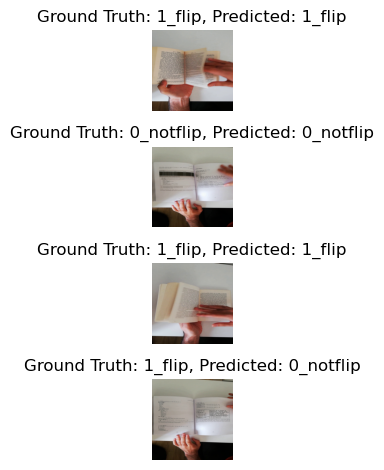

In [33]:
# switch off autograd
with torch.no_grad():
	# send the images to the device
	images = image.to(Device)
	# make the predictions
	preds = model(images)
	# loop over all the batch
	for i in range(0, Pred_batch_size):
		# initialize a subplot
		ax = plt.subplot(Pred_batch_size, 1, i + 1)
		# grab the image, de-normalize it, scale the raw pixel
		# intensities to the range [0, 255], and change the channel
		# ordering from channels first tp channels last
		image = images[i]
		image = deNormalize(image).cpu().numpy()
		image = (image * 255).astype("uint8")
		image = image.transpose((1, 2, 0))
		# grab the ground truth label
		idx = labels[i].cpu().numpy()
		gtLabel = testDataset.classes[idx]
		# grab the predicted label
		pred = preds[i].argmax().cpu().numpy()
		predLabel = testDataset.classes[pred]
		# add the results and image to the plot
		info = "Ground Truth: {}, Predicted: {}".format(gtLabel,
				predLabel)
		plt.imshow(image)
		plt.title(info)
		plt.axis("off")
	
	# show the plot
	plt.tight_layout()
	plt.show()

In [34]:
# logit
# pred
# pred.argmax(axis=1)
# test_pred
# pred.argmax(dim=-1)== targets
# targets

In [35]:
testDataset.classes[pred]

'0_notflip'

In [36]:
testDataset[pred]

(tensor([[[ 0.6392,  0.6221,  0.6221,  ...,  0.6049,  0.6049,  0.6049],
          [ 0.6392,  0.6392,  0.6221,  ...,  0.6049,  0.6049,  0.6049],
          [ 0.6049,  0.6049,  0.6049,  ...,  0.6049,  0.6049,  0.6049],
          ...,
          [-2.0152, -2.0152, -2.0152,  ..., -2.0837, -2.0837, -2.0837],
          [-2.0152, -2.0152, -2.0152,  ..., -2.0837, -2.0837, -2.0837],
          [-2.0152, -2.0152, -2.0152,  ..., -2.0837, -2.0837, -2.0837]],
 
         [[ 0.5553,  0.5378,  0.5378,  ...,  0.7129,  0.7129,  0.7129],
          [ 0.5553,  0.5553,  0.5378,  ...,  0.7129,  0.7129,  0.7129],
          [ 0.5553,  0.5553,  0.5553,  ...,  0.7129,  0.7129,  0.7129],
          ...,
          [-1.9657, -1.9657, -1.9657,  ..., -2.0007, -2.0007, -2.0007],
          [-1.9657, -1.9657, -1.9657,  ..., -2.0007, -2.0007, -2.0007],
          [-1.9657, -1.9657, -1.9657,  ..., -2.0007, -2.0007, -2.0007]],
 
         [[ 0.4788,  0.4614,  0.4439,  ...,  0.4962,  0.4962,  0.4962],
          [ 0.4788,  0.4788,

In [37]:
testDataset.classes

['0_notflip', '1_flip']

In [38]:
pred.shape

()